In [1]:
%matplotlib inline

In [2]:
import numpy as np
import kali.carma
import kali
import gatspy
from matplotlib import pyplot as plt
plt.rcParams["figure.figsize"] = [14,8]
from lsstlc import * # derived LSST lightcurve sub-class

/home/kali/python/kali/lc.py:29: UserWarning: No display environment! Using matplotlib backend "Agg"
  warnings.warn('No display environment! Using matplotlib backend "Agg"')
/home/conda/lib/python2.7/site-packages/matplotlib/__init__.py:1350: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


## Generate DRW LC

In [3]:
# load MAF output from file, which was saved from the obs_hist notebook
maf = np.load('/home/mount/MAF output/all_three.npz') 

# get the result for minion_1016, baseline cadence
bl_meta = maf['meta1'] # [ra, dec, min_gap, opsim_id], min_gap in hours
bl_cadence = maf['cadence1'] # cadence in structured array

# result for baseline with no pairs
bl_np_meta = maf['meta2']
bl_np_cadence = maf['cadence2']

#rolling cadence
roll_meta = maf['meta3']
roll_cadence = maf['cadence3']

In [4]:
# determine lowest seperation between three different cadence
sep = np.array([float(bl_meta[2]), float(bl_np_meta[2]), float(roll_meta[2])])
min_sep = np.min(sep)

### CARMA(1,0) task

In [5]:
# Initiate carma task
Task = kali.carma.CARMATask(1,0,nsteps = 500)

In [6]:
# declare input timescales and amplitude, organize in an array
r_1 = (-1.0/150.0) + 0j 
amp = 1.0
Rho = np.array([r_1, amp])

# use helper function to convert input to coefficients, and check whether valid
Theta = kali.carma.coeffs(1, 0, Rho) # use the array of roots above to solve for coefficients
print Theta # print out the calculated coefficients
print Task.check(Theta)

[ 0.00666667  0.11547005]
True


### Simulate DRW LC

In [7]:
dt = min_sep/24 # convert min_gap from hours to days, Kali uses days
Task.set(dt, Theta) # Will print 0 if parameters set successfuly

0

In [8]:
DRW_lc = Task.simulate(duration=3650)

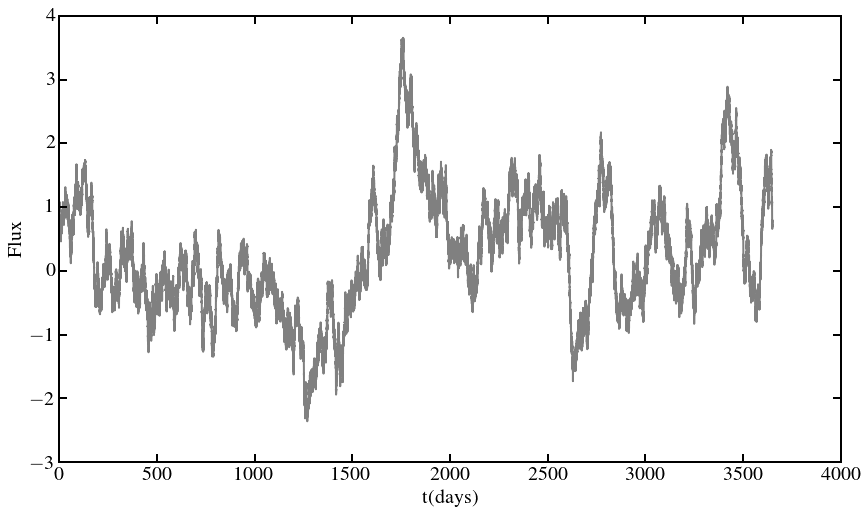

In [16]:
# plot simulated lightcurve
f = plt.figure()
plt.ylabel('Flux')
plt.xlabel('t(days)')
plt.plot(DRW_lc.t, DRW_lc.x, color='gray') # x is the variation about the mean flux

### Add noise (based on 100 SN ratio)

In [10]:
DRW_lc.fracNoiseToSignal = 0.01
Task.observe(DRW_lc)

#### Save to file

In [47]:
lc2file('/home/mount/c10_20_0_lc', DRW_lc)

## Downsample DRW

#### Baseline Cadence (minion_1016)

In [11]:
bl_down = lsstlc(bl_meta[0], bl_meta[1], bl_cadence['expDate'], DRW_lc, float(min_sep))

#### Baseline Cadence without exposure in pairs (kraken_1043)

In [12]:
bl_np_down = lsstlc(bl_meta[0], bl_meta[1], bl_np_cadence['expDate'], DRW_lc, float(min_sep))

#### Rolling Cadence V2 (enigma_1260)

In [13]:
roll_down = lsstlc(bl_meta[0], bl_meta[1], roll_cadence['expDate'], DRW_lc, float(min_sep))

### Plot down-sampled onto the whole mock lc

In [15]:
# get mean flux
mean = - np.mean(DRW_lc.x) + np.mean(DRW_lc.y)

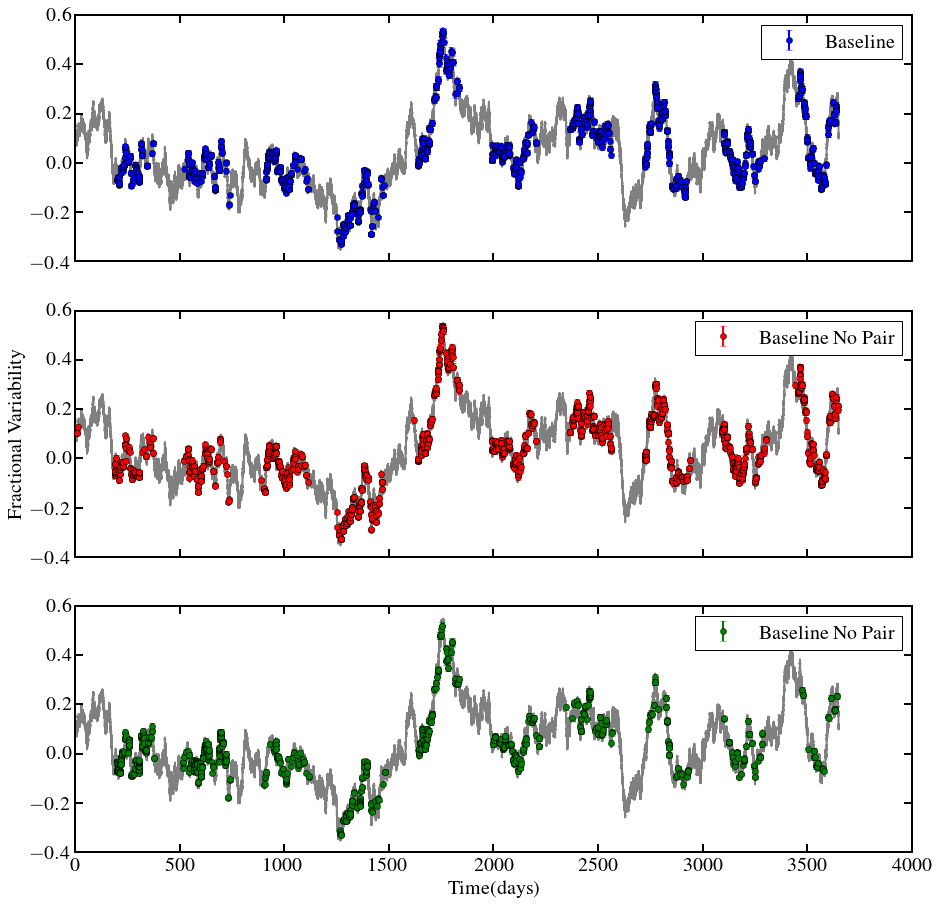

In [29]:
f, (ax1, ax2, ax3) = plt.subplots(3,1,sharex=True, sharey=True)
f.set_figheight(15)
f.set_figwidth(15)

# ax1.set(ylabel='Fractional Variability')
ax1.errorbar(bl_down.mock_t, bl_down.x/mean, bl_down.yerr/mean, fmt='o', label='Baseline', zorder=8)
ax1.plot(bl_down.mockLC.t, (bl_down.mockLC.x)/mean, color='gray')
ax1.legend(numpoints=1)

ax2.errorbar(bl_np_down.mock_t, bl_np_down.x/mean, bl_np_down.yerr/mean, color='r', 
             fmt='o', label='Baseline No Pair', zorder=8)
ax2.plot(bl_down.mockLC.t, (bl_down.mockLC.x)/mean, color='gray')
ax2.set(ylabel='Fractional Variability')
ax2.legend(numpoints=1)

ax3.errorbar(roll_down.mock_t, roll_down.x/mean, roll_down.yerr/mean, color='green', 
             fmt='o', label='Rolling Cadence', zorder=8)
ax3.plot(bl_down.mockLC.t, (bl_down.mockLC.x)/mean, color='gray')
ax3.set(xlabel='Time(days)')
ax3.legend(numpoints=1)

### Compare number of visit for each cadence

In [33]:
print 'The location of the sky we are looking at is ({}, {})'.format(bl_meta[0], bl_meta[1])
print 'The # of visit for baseline cadence: {}'.format(bl_down.x.shape[0])
print 'The # of visit for baseline cadence without pair exposures: {}'.format(bl_np_down.x.shape[0])
print 'The # of visit for rolling cadence: {}'.format(roll_down.x.shape[0])

The location of the sky we are looking at is (20, 0)
The # of visit for **baseline cadence**: 1815
The # of visit for baseline cadence without pair exposures: 1870
The # of visit for rolling cadence: 1234


### Now checkout the best-fit parameters

Here we are comparing two parameters, first one is $\tau$, the relexation time-scale, the second is $\sigma$ the amplitude of the variation.

In [34]:
Task.fit(bl_down)

0

In [41]:
print 'Baseline cadence (WFD+DDF), minion_1016'
print ' Input parameters: \n {}'.format([150, 1])
print ' Best-fit paremeters:\n {}'.format(Task.bestTau)

Baseline cadence (WFD+DDF), minion_1016
 Input parameters: 
 [150, 1]
 Best-fit paremeters:
 [ 136.32979243    0.95808435]


In [45]:
Task.clear()
Task.fit(bl_np_down)
print 'Baseline cadence (WFD+DDF) without pair exposure, kraken_1043'
print ' Input parameters: \n {}'.format([150, 1])
print ' Best-fit paremeters:\n {}'.format(Task.bestTau)

Baseline cadence (WFD+DDF) without pair exposure, kraken_1043
 Input parameters: 
 [150, 1]
 Best-fit paremeters:
 [ 131.93730842    0.94677594]


In [46]:
Task.clear()
Task.fit(roll_down)
print 'Rolling cadence, enigma_1260'
print ' Input parameters: \n {}'.format([150, 1])
print ' Best-fit paremeters:\n {}'.format(Task.bestTau)

Rolling cadence, enigma_1260
 Input parameters: 
 [150, 1]
 Best-fit paremeters:
 [ 142.45907714    0.96149633]
